In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

c:\Users\umarn\anaconda3\envs\IRTM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import matplotlib.dates as mdates

In [4]:
import os
import json
import numpy as np

In [5]:
df = pd.read_json("newsdata.json", lines=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [7]:
df['text'] = (
    df['headline'].fillna('') + ". " +
    df['short_description'].fillna('')
).str.strip()

In [8]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['time_bin'] = df['date'].dt.to_period('M').dt.to_timestamp()

df.head()

,link,headline,category,short_description,authors,date,text,time_bin
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-01
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",2022-09-01
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-01
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,2022-09-01
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-01


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
 6   text               209527 non-null  object        
 7   time_bin           209527 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(6)
memory usage: 12.8+ MB


In [10]:
df = df[df['text'].str.len() > 10].reset_index(drop=True) # filtering short texts in the dataset

In [ ]:
df = df.head(75000) #limitng the data for faster model fitting and output generation


In [12]:
df

,link,headline,category,short_description,authors,date,text,time_bin
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-01
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",2022-09-01
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-01
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,2022-09-01
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-01
...,...,...,...,...,...,...,...,...
24995,https://www.huffingtonpost.com/entry/student-p...,Student Protestors And Their Faculty Allies At...,COLLEGE,Four months have passed since the riots that b...,"Michael Zimmerman, ContributorFounder and Exec...",2017-09-17,Student Protestors And Their Faculty Allies At...,2017-09-01
24996,https://www.huffingtonpost.com/entry/a-classro...,A Classroom Of Tomorrow,EDUCATION,"Good morning, children, and welcome to today’s...","Peter Greene, ContributorTeacher, blogger, tai...",2017-09-17,"A Classroom Of Tomorrow. Good morning, childre...",2017-09-01
24997,https://www.huffingtonpost.com/entry/grindr-pr...,Watch What Happened When These Two Men Swapped...,QUEER VOICES,"""What The Flip?"" examines how racial stereotyp...",Curtis M. Wong,2017-09-17,Watch What Happened When These Two Men Swapped...,2017-09-01
24998,https://www.huffingtonpost.com/entry/hate-crim...,Exclusive: New Report Offers Proof Of US Hate ...,POLITICS,New data obtained by HuffPost shows hate crime...,Christopher Mathias,2017-09-17,Exclusive: New Report Offers Proof Of US Hate ...,2017-09-01


In [13]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")


In [14]:
topic_model = BERTopic(embedding_model=embed_model, verbose=True)

texts = df['text'].tolist()
topics, probs = topic_model.fit_transform(texts)

2025-12-06 22:59:23,038 - BERTopic - Embedding - Transforming documents to embeddings.


Batches: 100%|██████████| 782/782 [02:21<00:00,  5.51it/s]
2025-12-06 23:01:45,342 - BERTopic - Embedding - Completed ✓
2025-12-06 23:01:45,342 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-06 23:02:20,536 - BERTopic - Dimensionality - Completed ✓
2025-12-06 23:02:20,536 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-06 23:02:24,485 - BERTopic - Cluster - Completed ✓
2025-12-06 23:02:24,500 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-06 23:02:25,695 - BERTopic - Representation - Completed ✓


In [15]:
df['topic'] = topics
df['topic_prob'] = probs

In [16]:
topic_info = topic_model.get_topic_info()
valid_topics = topic_info[topic_info["Topic"] >= 0]["Topic"].tolist() #removing outlier topic

In [17]:
topic_names = {}

for t in valid_topics:
    words = topic_model.get_topic(t)
    topic_names[t] = ", ".join([w[0] for w in words[:4]])  # top 5 words



In [18]:
df["topic_name"] = df["topic"].map(topic_names)

df = df[df["topic"] != -1].reset_index(drop=True) #removing


In [19]:
topics_over_time = (
    df.groupby(['time_bin', 'topic'])
      .size()
      .reset_index(name='Frequency')
)


In [20]:
pivot = topics_over_time.pivot_table(
    index='time_bin',
    columns='topic',
    values='Frequency',
    fill_value=0
).sort_index()




In [21]:
pivot = pivot.drop(columns=[-1], errors='ignore')

pivot_norm = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)

In [22]:
rolling_mean = pivot_norm.rolling(3, min_periods=1, center=False).mean()

rolling_std = pivot_norm.rolling(3, min_periods=1, center=False).std(ddof=0)

std_floor = 1e-6
rolling_std = rolling_std.clip(lower=std_floor)

zscore = (pivot_norm - rolling_mean) / rolling_std
zscore = zscore.replace([np.inf, -np.inf], np.nan).fillna(0)


In [23]:
#zscore = (pivot_norm - rolling_mean) / rolling_std
#zscore = zscore.fillna(0)

In [24]:

topk = 6

top_k_ids = pivot_norm.sum().sort_values(ascending=False).head(topk).index.tolist()

top_topics = [topic_names[t] for t in top_k_ids]



In [ ]:
os.makedirs("saved_trains", exist_ok=True)

embeddings = embed_model.encode(texts, show_progress_bar=True, batch_size=64)
embeddings = embeddings.astype(np.float32)   # smaller on disk
np.save("saved_trains/embeddings.npy", embeddings)

topic_model.save("saved_trains/bertopic_model")

with open("saved_trains/topic_names.json", "w", encoding="utf-8") as f:
    json.dump(topic_names, f, ensure_ascii=False, indent=2)

metadata = {
    "embedding_model": "all-MiniLM-L6-v2",
    "n_documents": len(texts),
    "bertopic_version": topic_model.__version__ if hasattr(topic_model, "__version__") else None,
    "saved_at": pd.Timestamp.now().isoformat()
}
with open("saved_trains/metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Saved: saved_trains/embeddings.npy, saved_trains/bertopic_model/, saved_trains/topic_names.json, saved_trains/metadata.json")


Batches: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s]
2025-12-06 23:04:39,476 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved: saved_trains/embeddings.npy, saved_trains/bertopic_model/, saved_trains/topic_names.json, saved_trains/metadata.json


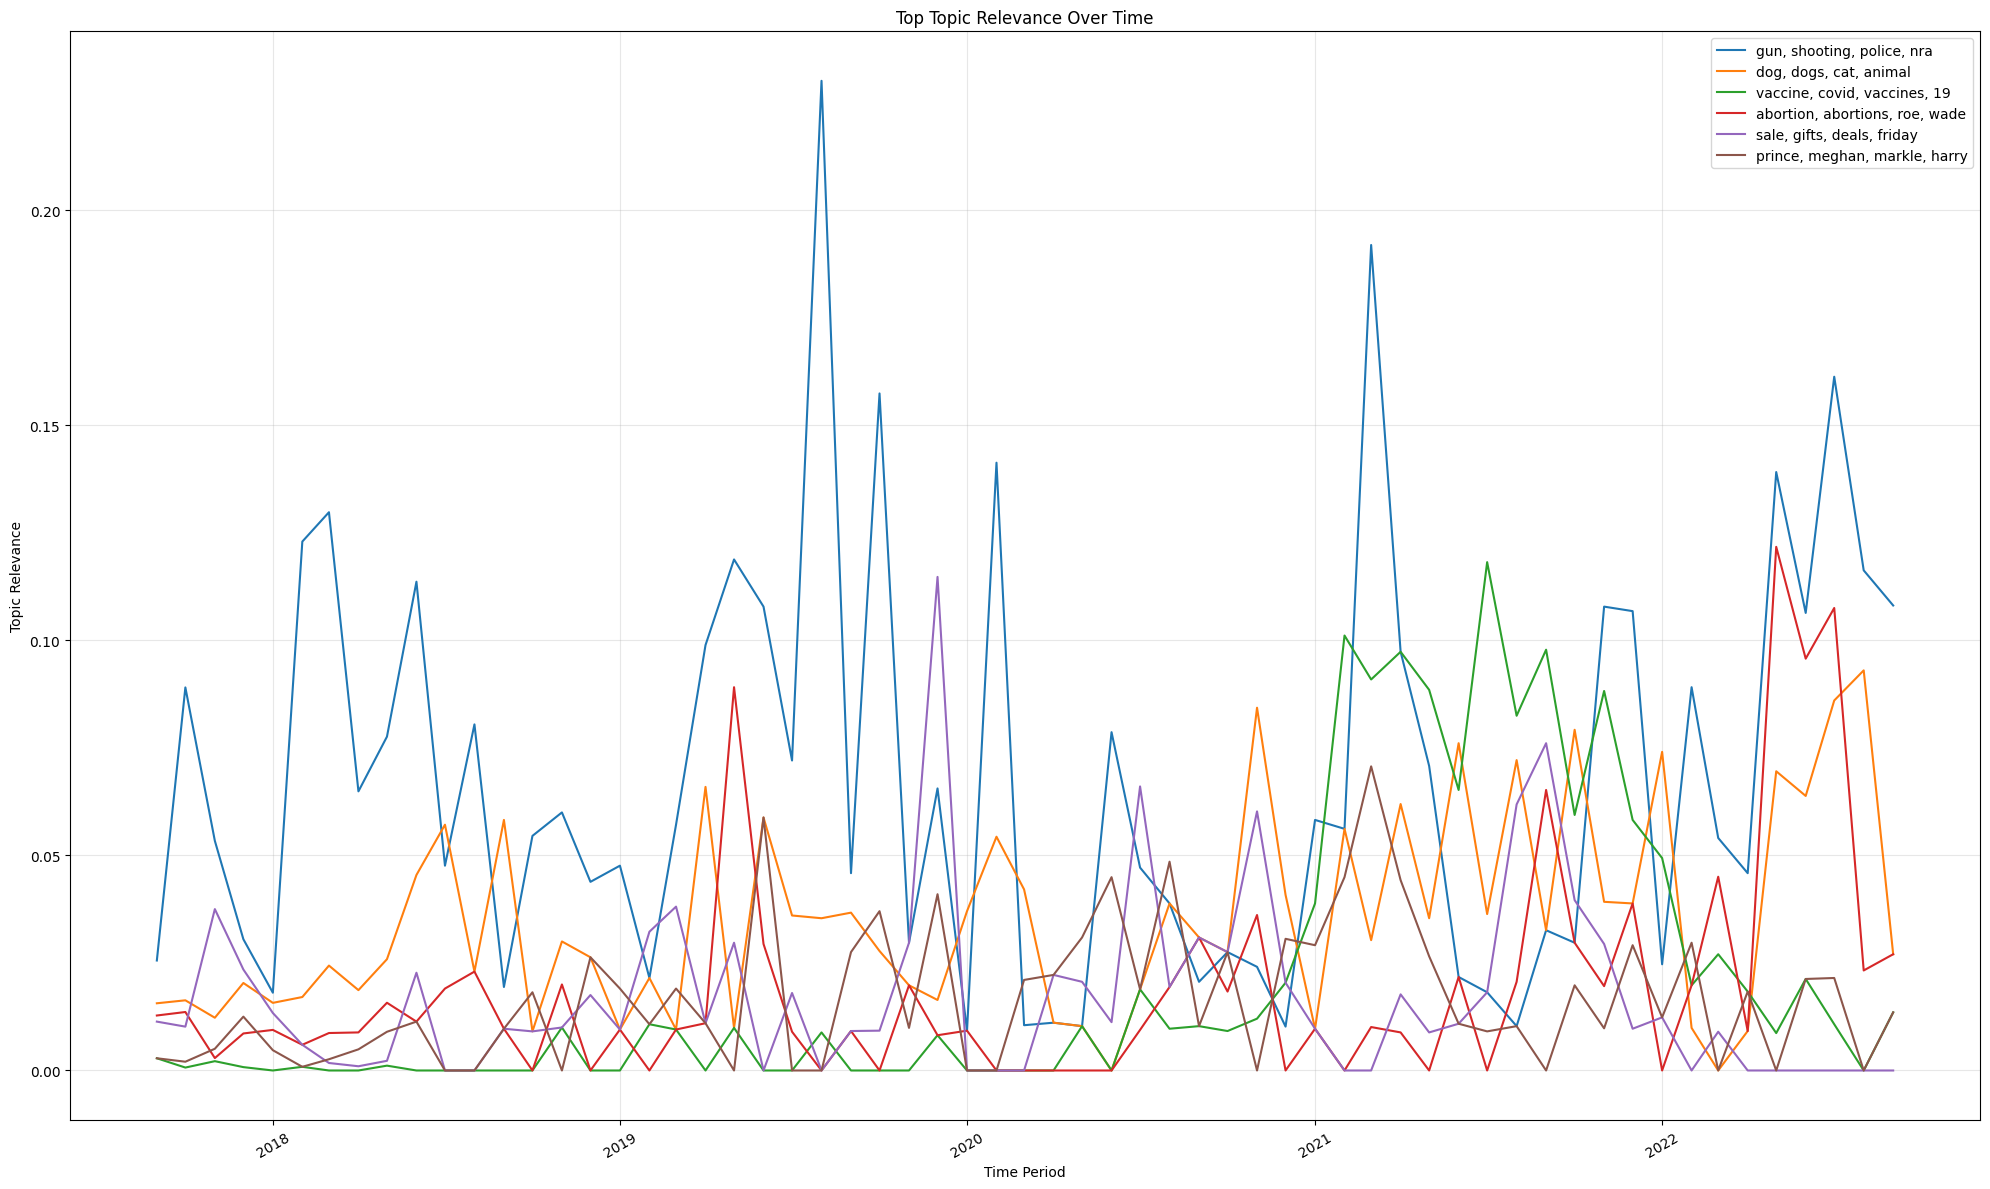

In [26]:
plt.figure(figsize=(20,12))

for t in top_k_ids:
    label = topic_names[t]   
    plt.plot(pivot_norm.index, pivot_norm[t], label=label)

plt.xlabel("Time Period")
plt.ylabel("Topic Relevance")
plt.title("Top Topic Relevance Over Time")
plt.xticks(rotation=30)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


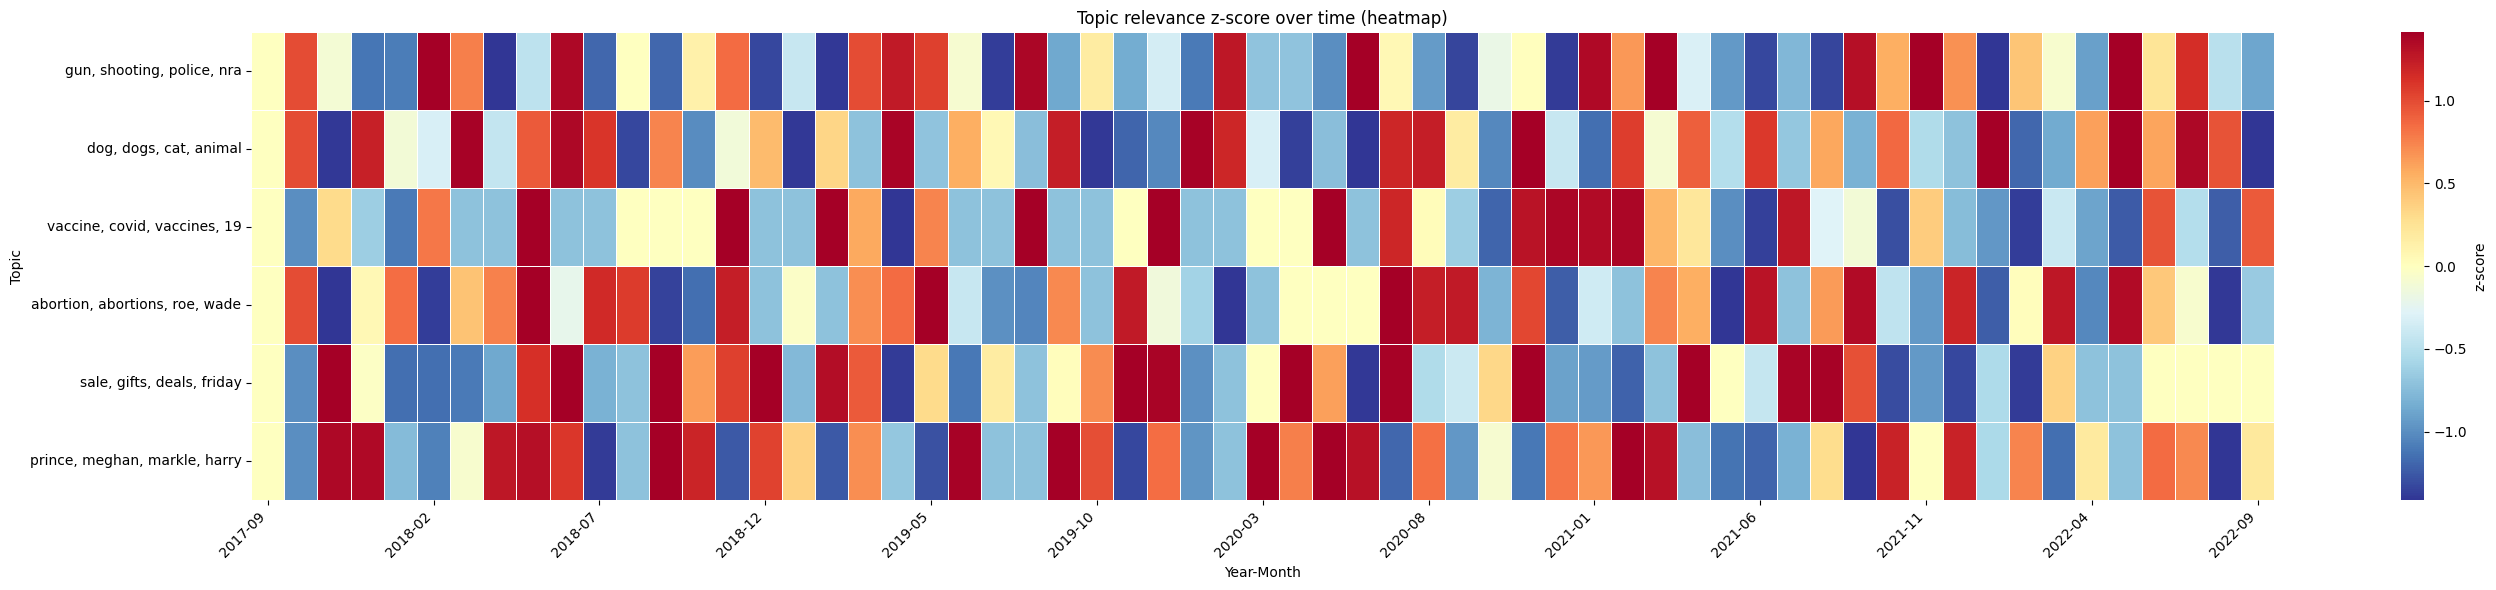

In [27]:


heat_ids = [t for t in top_k_ids if t in zscore.columns]
heat_df = zscore[heat_ids].T.copy()
heat_df.index = [topic_names[t] for t in heat_df.index]  # using topic names here


plt.figure(figsize=(28, 6))
ax = sns.heatmap(heat_df, cmap='RdYlBu_r', center=0, cbar_kws={'label': 'z-score'}, linewidths=0.5, linecolor='white')

time_bins = zscore.index.to_list()
labels = [d.strftime('%Y-%m') for d in time_bins]

n_ticks = len(labels)
tick_step = max(1, n_ticks // 12)

ax.set_xticks(np.arange(0, n_ticks, tick_step) + 0.5)
ax.set_xticklabels([labels[i] for i in range(0, n_ticks, tick_step)], rotation=45, ha='right')

ax.set_xlabel('Year-Month')
ax.set_ylabel('Topic')
ax.set_title('Topic relevance z-score over time (heatmap)')
plt.tight_layout()
plt.show()
